# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

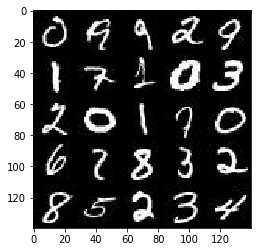

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

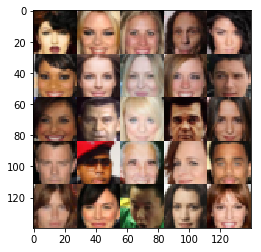

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name ='learning_rate')

    return (inputs_real, inputs_z, learning_rate)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 256, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())
        # 14x14x256
        
        x2 = tf.layers.conv2d(relu1, 512, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(x2.get_shape())
        # 7x7x512
        

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse = not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train) #is_train???
        x1 = tf.maximum(alpha * x1, x1) #Leaky ReLu
        #print (x1.get_shape().as_list())
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print (x2.get_shape().as_list())
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print (x3.get_shape().as_list())
        # 14x14x128 now
        
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same') #no batch normalization
        # 28x28xout_channel_dim now
        #print (logits.get_shape().as_list())
        #print (out_channel_dim)
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # TODO: Implement Function
    alpha = 0.2
    smooth=0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    #d_loss_real = tf.reduce_mean(
        #tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)#
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph() #this line killed me two days
    
    print(data_shape)
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    #steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            steps = 0
            
            for batch_images in get_batches(batch_size):
            # TODO: Train Model
                
                
                steps += 1 
                batch_images = batch_images*2 #to match with generator tanh output 
                #print(batch_images.shape)
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                

                if steps % 10 == 0:
                    #print (steps/10)
                    # At the end of each epoch, get the losses and print them out
                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)

                
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.8525
Epoch 1/2... Discriminator Loss: 7.5881... Generator Loss: 0.0011
Epoch 1/2... Discriminator Loss: 4.0027... Generator Loss: 0.2913
Epoch 1/2... Discriminator Loss: 2.3137... Generator Loss: 6.1456
Epoch 1/2... Discriminator Loss: 1.6950... Generator Loss: 1.5390
Epoch 1/2... Discriminator Loss: 1.5767... Generator Loss: 2.4904
Epoch 1/2... Discriminator Loss: 1.9489... Generator Loss: 0.5266
Epoch 1/2... Discriminator Loss: 1.5227... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 2.3337... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 2.7433... Generator Loss: 0.5640


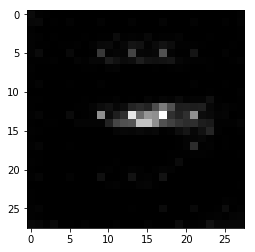

Epoch 1/2... Discriminator Loss: 2.9790... Generator Loss: 0.2350
Epoch 1/2... Discriminator Loss: 1.6513... Generator Loss: 0.5494
Epoch 1/2... Discriminator Loss: 2.4934... Generator Loss: 1.5168
Epoch 1/2... Discriminator Loss: 1.7725... Generator Loss: 0.9444
Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 1.6070
Epoch 1/2... Discriminator Loss: 1.9248... Generator Loss: 1.1654
Epoch 1/2... Discriminator Loss: 1.6785... Generator Loss: 1.1560
Epoch 1/2... Discriminator Loss: 1.6351... Generator Loss: 1.4276
Epoch 1/2... Discriminator Loss: 1.5482... Generator Loss: 1.1370
Epoch 1/2... Discriminator Loss: 1.4496... Generator Loss: 1.1664


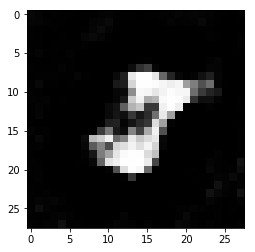

Epoch 1/2... Discriminator Loss: 1.6611... Generator Loss: 0.4711
Epoch 1/2... Discriminator Loss: 1.7642... Generator Loss: 0.5440
Epoch 1/2... Discriminator Loss: 1.4860... Generator Loss: 0.5502
Epoch 1/2... Discriminator Loss: 1.9391... Generator Loss: 0.4391
Epoch 1/2... Discriminator Loss: 1.5925... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 1.8823... Generator Loss: 1.6273
Epoch 1/2... Discriminator Loss: 1.5448... Generator Loss: 1.4095
Epoch 1/2... Discriminator Loss: 1.5088... Generator Loss: 0.5497
Epoch 1/2... Discriminator Loss: 1.5354... Generator Loss: 0.4897
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.7415


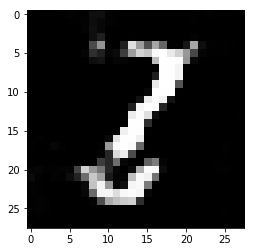

Epoch 1/2... Discriminator Loss: 1.5559... Generator Loss: 0.4719
Epoch 1/2... Discriminator Loss: 1.4881... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 1.5899... Generator Loss: 0.5699
Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 1.6191
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 1.2541
Epoch 1/2... Discriminator Loss: 1.6713... Generator Loss: 1.2860
Epoch 1/2... Discriminator Loss: 1.3098... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.6843... Generator Loss: 0.3867
Epoch 1/2... Discriminator Loss: 1.4867... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 1.6473... Generator Loss: 0.6065


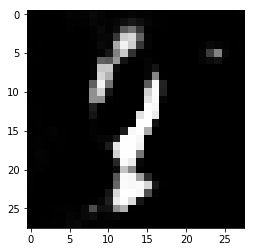

Epoch 1/2... Discriminator Loss: 1.4777... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 1.6195... Generator Loss: 1.0283
Epoch 1/2... Discriminator Loss: 1.6274... Generator Loss: 0.4522
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.9339
Epoch 1/2... Discriminator Loss: 1.5452... Generator Loss: 1.1105
Epoch 1/2... Discriminator Loss: 1.5748... Generator Loss: 1.2447
Epoch 2/2... Discriminator Loss: 1.6470... Generator Loss: 1.4310
Epoch 2/2... Discriminator Loss: 1.4740... Generator Loss: 1.0212
Epoch 2/2... Discriminator Loss: 1.5658... Generator Loss: 1.3431
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 1.1637
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 1.2204
Epoch 2/2... Discriminator Loss: 1.7144... Generator Loss: 1.8837
Epoch 2/2... Discriminator Loss: 1.4486... Generator Loss: 0.6354
Epoch 2/2... Discriminator Loss: 1.4856... Generator Loss: 0.5622
Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 1.0745
Epoch 2/2.

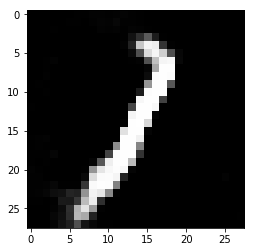

Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 1.1445
Epoch 2/2... Discriminator Loss: 1.9478... Generator Loss: 2.1748
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 1.7438
Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 1.1643
Epoch 2/2... Discriminator Loss: 1.5360... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.3271... Generator Loss: 0.7969
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 1.4217... Generator Loss: 0.5121
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.7051


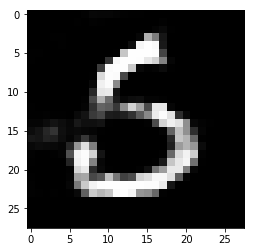

Epoch 2/2... Discriminator Loss: 1.4841... Generator Loss: 0.5703
Epoch 2/2... Discriminator Loss: 1.5577... Generator Loss: 1.5727
Epoch 2/2... Discriminator Loss: 1.4004... Generator Loss: 1.1798
Epoch 2/2... Discriminator Loss: 2.3800... Generator Loss: 2.5322
Epoch 2/2... Discriminator Loss: 1.4532... Generator Loss: 1.1510
Epoch 2/2... Discriminator Loss: 1.5271... Generator Loss: 0.5854
Epoch 2/2... Discriminator Loss: 1.6053... Generator Loss: 0.4199
Epoch 2/2... Discriminator Loss: 1.5010... Generator Loss: 1.5067
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.7856
Epoch 2/2... Discriminator Loss: 1.7102... Generator Loss: 0.4236


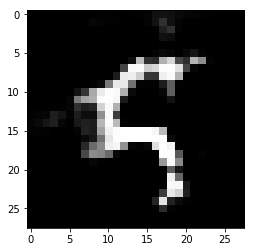

Epoch 2/2... Discriminator Loss: 1.3497... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 1.3419... Generator Loss: 0.9920
Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 1.2194
Epoch 2/2... Discriminator Loss: 1.4524... Generator Loss: 0.6673
Epoch 2/2... Discriminator Loss: 1.4153... Generator Loss: 0.5402
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 1.1551
Epoch 2/2... Discriminator Loss: 1.5042... Generator Loss: 0.4847
Epoch 2/2... Discriminator Loss: 1.6454... Generator Loss: 0.4260
Epoch 2/2... Discriminator Loss: 1.2548... Generator Loss: 0.8567
Epoch 2/2... Discriminator Loss: 1.2392... Generator Loss: 1.2742


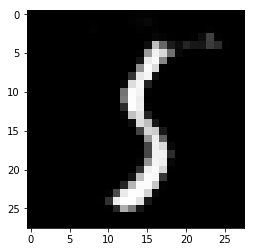

Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 1.0234
Epoch 2/2... Discriminator Loss: 1.3503... Generator Loss: 1.0687
Epoch 2/2... Discriminator Loss: 1.7178... Generator Loss: 1.8140
Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 1.3674
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.6538
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.8056


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 4.6800... Generator Loss: 0.0237
Epoch 1/1... Discriminator Loss: 3.0891... Generator Loss: 0.2612
Epoch 1/1... Discriminator Loss: 5.5135... Generator Loss: 0.0207
Epoch 1/1... Discriminator Loss: 2.9310... Generator Loss: 5.3887
Epoch 1/1... Discriminator Loss: 2.4217... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 2.1954... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 2.0348... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 2.9444... Generator Loss: 0.1312
Epoch 1/1... Discriminator Loss: 1.7434... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 1.3238


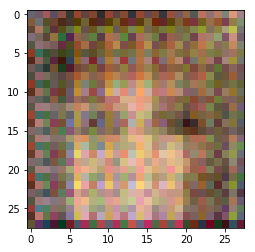

Epoch 1/1... Discriminator Loss: 1.8209... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 2.8564... Generator Loss: 2.0204
Epoch 1/1... Discriminator Loss: 2.1708... Generator Loss: 0.3475
Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 2.2232... Generator Loss: 0.3580
Epoch 1/1... Discriminator Loss: 1.8372... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 2.0794... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.7588... Generator Loss: 0.6622


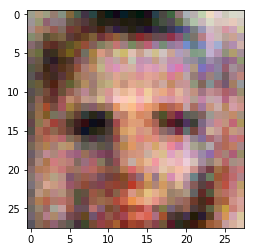

Epoch 1/1... Discriminator Loss: 1.8040... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.6938... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.7362... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.5614... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 2.0045
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.7259


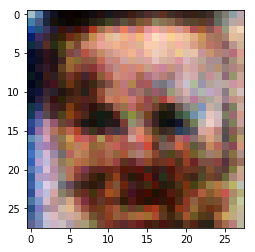

Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 1.5425
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.8164... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 1.4489
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.7625


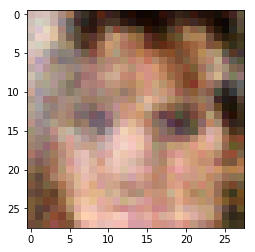

Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 1.4940
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 1.7301... Generator Loss: 0.3588
Epoch 1/1... Discriminator Loss: 1.6379... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.8108... Generator Loss: 1.9306
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.6110... Generator Loss: 0.4811
Epoch 1/1... Discriminator Loss: 1.8883... Generator Loss: 0.3723


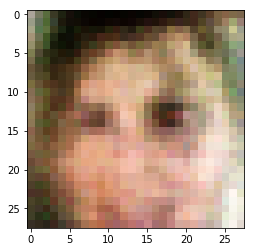

Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 2.0307
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.0442
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 1.3893
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 1.2690
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8109


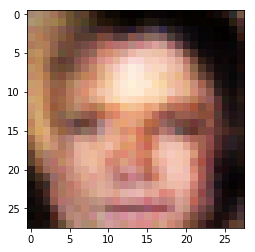

Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.4300
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.6946... Generator Loss: 0.3504
Epoch 1/1... Discriminator Loss: 1.5589... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.7227... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 1.2000
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.7993


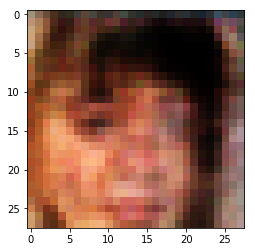

Epoch 1/1... Discriminator Loss: 1.9160... Generator Loss: 1.7088
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.6730... Generator Loss: 0.3433
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.6801... Generator Loss: 0.4285
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 1.1209


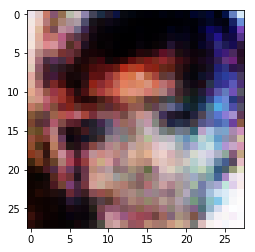

Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.4612
Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.8967... Generator Loss: 1.3407
Epoch 1/1... Discriminator Loss: 1.6608... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 1.9224


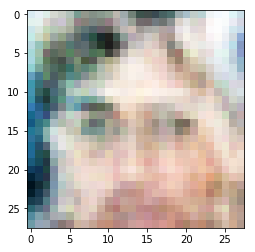

Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.6404... Generator Loss: 0.3748
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 1.4886


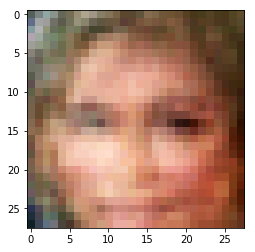

Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.6036... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.6986... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.5372
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6185


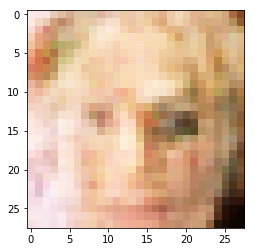

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 1.5400
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 1.3794
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 1.0015


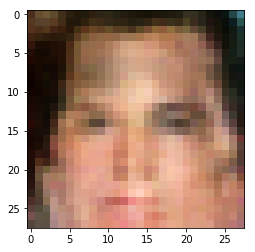

Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.7006... Generator Loss: 1.4224
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.6610... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.4234
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.5870


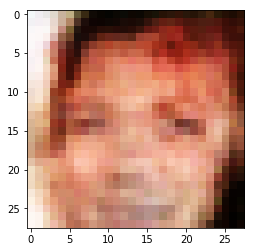

Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 1.1046


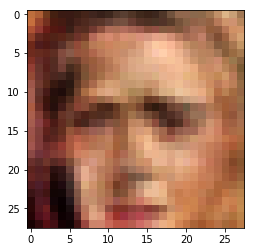

Epoch 1/1... Discriminator Loss: 1.8264... Generator Loss: 0.3261
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 1.3484
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.9506


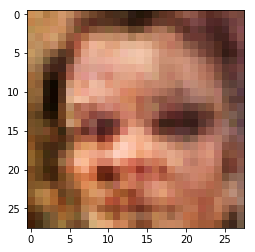

Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 1.6856
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 1.2277
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 1.2044
Epoch 1/1... Discriminator Loss: 2.7054... Generator Loss: 0.1853


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.